In [1]:
import numpy as np
import tensorflow as tf
from skimage import color, data
from skimage.transform import rescale
import scipy.ndimage.filters as fi


def gaussian(kernlen, nsig_x, nsig_y):
    inp = np.zeros((kernlen, kernlen))
    inp[kernlen//2, kernlen//2] = 1
    kern = fi.gaussian_filter(inp, (nsig_x, nsig_y))
    scaled_kern = kern / np.sum(kern)
    return scaled_kern


def tf_convolve_2d(image, psf):
    tf_image = tf.reshape(image, (1, tf.shape(image)[0], tf.shape(image)[1], 1))
    tf_psf = tf.reshape(psf, (tf.shape(psf)[0], tf.shape(psf)[1], 1, 1))
    tf_output = tf.nn.conv2d(tf_image, tf_psf, [1, 1, 1, 1], 'SAME')[0, :, :, 0]
    return tf_output


def convolve(image, psf):
    sess = tf.Session()
    tf_image = tf.constant(image, dtype=tf.float32)
    tf_psf = tf.constant(psf, dtype=tf.float32)
    tf_output = tf_convolve_2d(tf_image, tf_psf)
    output = sess.run(tf_output)
    return output

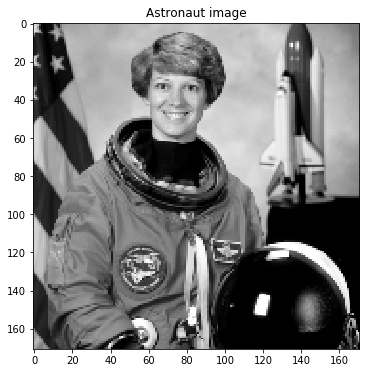

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

astro_org = rescale(color.rgb2gray(data.astronaut()), 1.0/3.0, mode='constant')

plt.figure(figsize=(6, 6))
plt.gray()
plt.imshow(astro_org)
plt.title('Astronaut image');

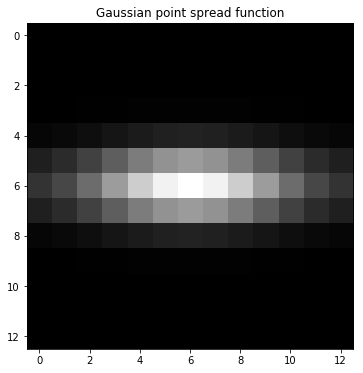

In [3]:
psf = gaussian(kernlen=13, nsig_x=1, nsig_y=3)

plt.figure(figsize=(6, 6))
plt.imshow(psf)
plt.title('Gaussian point spread function');

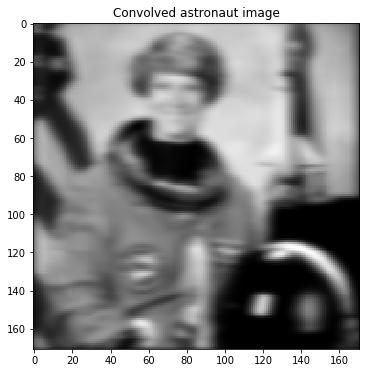

In [4]:
astro_conv = convolve(astro_org, psf)

plt.figure(figsize=(6, 6))
plt.imshow(astro_conv)
plt.title('Convolved astronaut image');

In [8]:
def deconvolve(image, psf, learning_rate=1e-2):
    loss_history = []

    tf_input = tf.Variable(np.random.randn(*image.shape) / 10.0, dtype=tf.float32)
    tf_psf = tf.constant(psf, dtype=tf.float32)
    tf_gt_output = tf.constant(image, dtype=tf.float32)
    tf_output = tf_convolve_2d(tf_input, tf_psf)

    loss = tf.reduce_sum(tf.square(tf_output - tf_gt_output))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    train = optimizer.minimize(loss)

    # training loop
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    def eval_step(i=0):
        tmp_loss = sess.run(loss)
        loss_history.append(tmp_loss)
        if i % 100 == 0:
            print('loss: {}'.format(tmp_loss))

    eval_step()
    for i in range(500):
        sess.run(train)
        eval_step(i)
    res_input = sess.run(tf_input)

    return res_input, loss_history

loss: 7404.30712890625
loss: 7123.0478515625
loss: 181.62457275390625
loss: 17.089582443237305
loss: 7.124327182769775
loss: 4.477963924407959


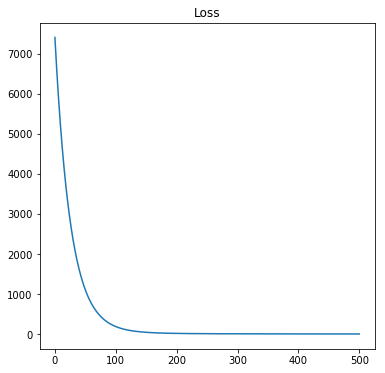

In [10]:
astro_deconv, loss = deconvolve(astro_conv, psf)

plt.figure(figsize=(6, 6))
plt.plot(loss)
plt.title('Loss');

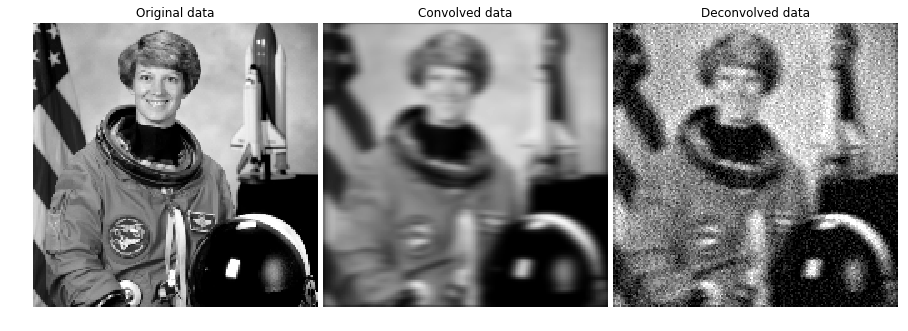

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

for a in ax:
    a.axis('off')

ax[0].imshow(astro_org, vmin=astro_org.min(), vmax=astro_org.max())
ax[0].set_title('Original data')

ax[1].imshow(astro_conv, vmin=astro_org.min(), vmax=astro_org.max())
ax[1].set_title('Convolved data')

ax[2].imshow(astro_deconv, vmin=astro_org.min(), vmax=astro_org.max())
ax[2].set_title('Deconvolved data')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)